# Toy example of unseasoning a dataset

In [38]:
import numpy as np
import xarray as xr
import netCDF4 as nc
import tpt_utils

In [39]:
import matplotlib.pyplot as plt 
%matplotlib inline

Create an annual cycle with 365 days, and every fourth year has a leap day.

In [40]:
num_years = 100
days_per_year = 365*np.ones(num_years, dtype=int)
days_per_year[np.arange(num_years) % 4 == 0] += 1 # Add a leap day to every fourth year
avg_year_length = np.mean(days_per_year)
day_of_year = np.concatenate([np.arange(days_per_year[i]) for i in range(len(days_per_year))])
time = np.arange(np.sum(days_per_year))

Create a toy dataset of temperature over an Earth with three discrete longitude cells and two discrete latitude cells. 

In [55]:
lon = np.array([0.0, 120.0, 240.0]) 
lat = np.array([45.0, -45.0])
temp = xr.DataArray(
    coords = {"lon": lon, "lat": lat, "time": time},
    dims = ["lon", "lat", "time"]
)
angular_frequency = 2*np.pi/avg_year_length
temp[dict(lat=0)] = (
    273.0 + 
    30.0*np.sin(temp["time"] * angular_frequency) + 
    15.0*np.sin(10 * temp["time"] * angular_frequency) +
    3.0*np.random.randn(temp["time"].size)
)
temp[dict(lat=1)] = (
    273.0 + 
    30.0*np.cos(temp["time"] * angular_frequency) + 
    15.0*np.sin(10 * temp["time"] * angular_frequency) +
    3.0*np.random.randn(temp["time"].size)
)

The seasonal mean will be calculated by aggregating days together that share a common feature `t_szn`

In [56]:
t_szn = temp["time"] % avg_year_length

Now we re-format the data in order to take advantage of `tpt_utils.project_field`. The first dimension is the number of observations (here, the number of days), and the second dimension is the number of "fields" we want to unseason (here, the number of lat-lon points). 

In [63]:
field = temp.copy(deep=True).data.transpose((2,0,1)) # Re-order coordinates: time comes first, and then spatial dimensions
field_unraveled = field.reshape((field.shape[0], field.size//field.shape[0])) # Reshape data so each lat-lon grid cell is a different field
weights = np.ones(field_unraveled.shape) # Optionally re-weight the observed samples
features = t_szn.data.reshape(-1,1) # This is the feature we want to divide into bins 
num_bins = 10 # arbitrary. If we want a daily average, choose 365 or 366
szn_stats_dict, edges, centers = tpt_utils.project_field(
    field_unraveled, weights, features, shp=[num_bins] 
)
szn_stats_da = xr.DataArray(
    coords = {"t_szn": centers[0], "lon": temp["lon"], "lat": temp["lat"], "statistic": list(szn_stats_dict.keys())},
    dims = ["t_szn","lon","lat","statistic"]
)
for stat_key in szn_stats_da["statistic"].data:
    szn_stats_da.loc[dict(statistic=stat_key)] = szn_stats_dict[stat_key].reshape(
        (centers[0].size, temp["lon"].size, temp["lat"].size))

Now unseason the original field. First we determine which bin each data point lands in, and second we subtract the corresponding mean. 

In [64]:
dt_szn = edges[0][1] - edges[0][0] # The bin size
szn_window = ((t_szn - edges[0][0])/dt_szn).astype(int) # The bin into which each data point falls
field_unraveled_unseasoned = (
    (field_unraveled - szn_stats_dict["mean"][szn_window]) / 
    szn_stats_dict["std"][szn_window] # With more realistic examples, also should divide by standard deviation
)
temp_unseasoned = temp.copy(deep=True)
temp_unseasoned[:] = field_unraveled_unseasoned.transpose((1,0)).reshape(temp.shape)

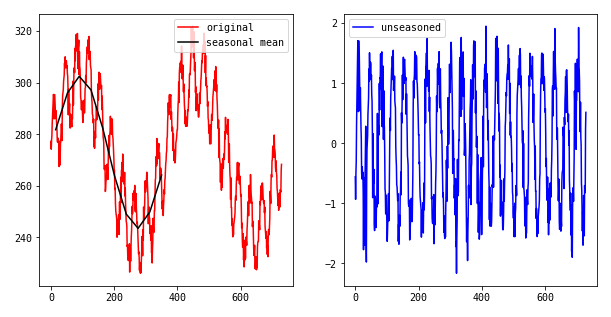

In [65]:
fig,ax = plt.subplots(ncols=2, figsize=(10,5))
# Plot the original timeseries 
i_time_max = int(2 * avg_year_length)
h0, = ax[0].plot(temp['time'][:i_time_max], temp.isel(lon=0,lat=0)[:i_time_max], color='red', label='original')
h1, = ax[0].plot(
    szn_stats_da["t_szn"], 
    szn_stats_da.sel(statistic="mean").isel(lon=0,lat=0), 
    color='black', label="seasonal mean")
ax[0].legend(handles=[h0,h1])
h2, = ax[1].plot(temp_unseasoned['time'][:i_time_max], temp_unseasoned.isel(lon=0,lat=0)[:i_time_max], color='blue', label='unseasoned')
ax[1].legend(handles=[h2])